# Rescomp Data Analysis

In [1]:
import rescomp as rc
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate, sparse
from scipy.stats import pearsonr
from scipy.sparse.linalg import eigs, ArpackNoConvergence
from scipy.sparse import coo_matrix
import math 
import networkx as nx
import itertools
import csv
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
# Set seed for reproducibility
np.random.seed(1)
from math import comb
import h5py
from mpi4py import MPI
from glob import glob
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: login04
--------------------------------------------------------------------------


In [ ]:
results_path = '/mnt/c/Users/dseyf/SeniorLabs/Research/Network_Theory/thinned_rescomp/results/'
# p_thins = np.concatenate((np.arange(0, 0.8, 0.1), np.arange(0.8, 0.99, 0.02)))
# rhos = [0.1,0.9,1.0,1.1,2.0,5.0,10.0,25.0,50.0]

rhos = [.01, .1, 1., 2., 5., 10., 20., 35., 50.]
p_thins = [0., .1, .2, .4, .6, .8, .9, .96, 1.]

In [3]:
def get_file_data(hdf5_file='results/erdos_results_0.h5'):
    """
    
    """

    with h5py.File(hdf5_file, 'r') as file:
        vpt_thinned_list = []
        div_pos_thinned_list = []
        div_der_thinned_list = []
        consistency_thinned_list = []

        for group_name in file.keys():
            group = file[group_name]
            if 'mean_vpt_thinned' not in list(group.attrs):
                continue
            vpt_thinned_list.append(group.attrs['mean_vpt_thinned'])
            div_pos_thinned_list.append(group.attrs['div_pos_thinned'])
            div_der_thinned_list.append(group.attrs['div_der_thinned'])
            consistency_thinned_list.append(group.attrs['mean_consistency_thinned'])
            # print('{}, c: {}, vpt_connected: {}, p_thin: {}, vpt_thinned: {}'.format(group_name, c, vpt_connected, p_thin, vpt_thinned))
        # print('vpt_connected_average: {}, vpt_thinned_average: {}'.format(np.mean(vpt_connected_list), np.mean(vpt_thinned_list)))
        
        mean_vpt = np.mean(vpt_thinned_list)
        mean_div_pos = np.mean(div_pos_thinned_list)
        mean_div_der = np.mean(div_der_thinned_list)
        mean_consistency = np.mean(consistency_thinned_list)
        print(f"Number of draws successfully made for {hdf5_file}: {len(vpt_thinned_list)}")
        print(f"Mean diversity: {mean_div_pos, mean_div_der}")
        
        return mean_vpt, mean_div_pos, mean_div_der, mean_consistency

In [4]:
def get_system_data(p_thins, rhos, results_path=results_path):
    """
    
    """
    mean_vpts = np.zeros((len(rhos), len(p_thins)))
    mean_pos_divs = np.zeros((len(rhos), len(p_thins)))
    mean_der_divs = np.zeros((len(rhos), len(p_thins)))
    mean_consistencies = np.zeros((len(rhos), len(p_thins)))

    for i, rho in enumerate(rhos):
        for j, p_thin in enumerate(p_thins):
            hdf5_file = results_path + f"erdos_results_rho={round(rho,2)}_p_thin={round(p_thin,2)}.h5"
            mean_vpts[i,j], mean_pos_divs[i,j], mean_der_divs[i,j], mean_consistencies[i,j] = get_file_data(hdf5_file=hdf5_file)
            print("VPT", mean_vpts[i,j])

    print(f"Overall: {np.max(mean_consistencies), np.min(mean_consistencies)}")
    return mean_vpts, mean_pos_divs, mean_der_divs, mean_consistencies

In [5]:
def create_system_plot(values, ax, title, threshold):
    """
    
    """

    cmap = 'viridis'
    # norm = matplotlib.colors.Normalize(vmin=0, vmax=np.max(values[np.isfinite(values)]))
    norm = matplotlib.colors.Normalize(vmin=0, vmax=min([np.max(values[np.isfinite(values)]), threshold]))
    sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Create evenly spaced grid for plotting
    x_even = np.linspace(0, 1, len(p_thins))  # evenly spaced x-coordinates
    y_even = np.linspace(0, 1, len(rhos))  # evenly spaced y-coordinates

    # X, Y = np.meshgrid(p_thins, rhos)
    ax.pcolormesh(x_even, y_even, values, shading='nearest', norm=norm, cmap=cmap)
    # ax.pcolormesh(X, Y, values, shading='nearest', cmap=cmap)
    
    ax.set_title(title)
    ax.set_xlabel('p_thin')
    ax.set_ylabel('rho')
    ax.set_xticks(x_even)
    ax.set_xticklabels(p_thins)  # map to original uneven x-values
    ax.set_yticks(y_even)
    ax.set_yticklabels(rhos)  # map to original uneven y-values
    ax.set_aspect('equal', adjustable='box')  # Ensure square cells

    
    # Format the ticks to show 1 decimal place and set them as labels
    ticks = ax.get_xticks()
    ax.set_xticklabels([f'{tick:.1f}' for tick in ticks])

    # Reduce visible x-axis labels
    labels = ax.get_xticklabels()
    for i, label in enumerate(labels):
        if i % 3 != 0:  # Show every 3rd label
            label.set_visible(False)
    
    plt.colorbar(mappable=sm, ax=ax)

In [6]:
def create_plots(mean_values=None, thresholds=[10,10,10,10], cutoff=False):
    fig, axs = plt.subplots(1,4, figsize=(14,3.2))
    
    if mean_values is None:
        mean_values = get_system_data(p_thins, rhos, results_path=results_path)

    titles = ['VPT', 'Div_Pos', 'Div_Der', 'Consistency']

    for i in range(len(mean_values)):
        if cutoff:
            mean_values[i][mean_values[i] > thresholds[i]] = 0
        create_system_plot(mean_values[i], axs[i], titles[i], thresholds[i])

    plt.tight_layout()
    plt.show()

### Analysis on c=4

In [7]:
# results_1_path = results_path + 'erdos_results_rho=2.0_p_thin=0.1.h5'
# get_file_data(hdf5_file=results_1_path)

In [8]:
mean_values = get_system_data(p_thins, rhos, results_path=results_path)

Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/erdos_results_rho=0.01_p_thin=0.0.h5: 430
Mean diversity: (0.29417351041381484, 0.00861199595271858)
VPT 1.8077441860465124
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/erdos_results_rho=0.01_p_thin=0.1.h5: 426
Mean diversity: (0.2945884380407571, 0.008505836930234123)
VPT 1.131314553990611
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/erdos_results_rho=0.01_p_thin=0.2.h5: 426
Mean diversity: (0.29038014717431704, 0.00831375678505042)
VPT 0.4146478873239447
Number of draws successfully made for /nobackup/autodelete/usr/seyfdall/network_theory/thinned_rescomp/results/erdos_results_rho=0.01_p_thin=0.4.h5: 247
Mean diversity: (0.29433661560582414, 0.008741474992726993)
VPT 0.7804453441295556
Number of draws successfully made for /nobackup/autodelete/u

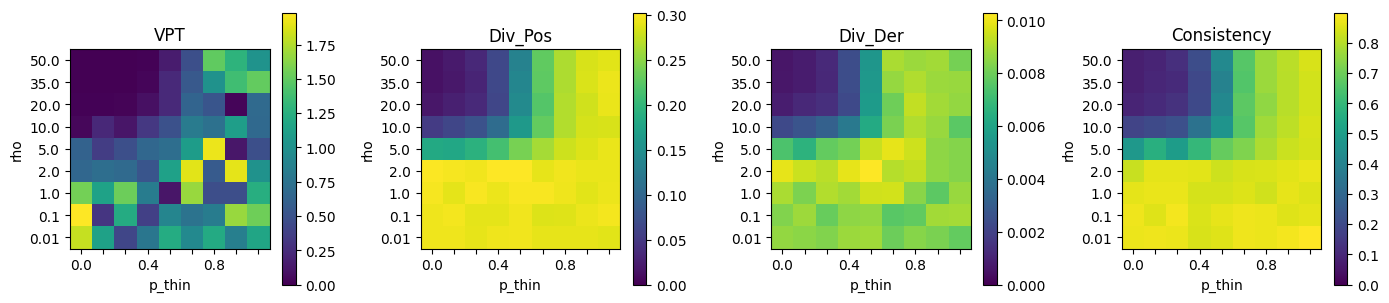

In [9]:
create_plots(mean_values, thresholds=[3, 10, 10, 10], cutoff=False)

### Diversity Plots for each cell

In [10]:
hdf5_file='results/erdos_results_rho=50.0_p_thin=0.0.h5'
with h5py.File(hdf5_file, 'r') as file:

    div_der = []
    div_pos = []

    for group_name in file.keys():
        group = file[group_name]
        if 'mean_vpt_thinned' not in list(group.attrs):
            continue
        print(group_name)
        div_der.append(group['div_der_thinned'][0])
        div_pos.append(group['div_pos_thinned'][0])
        # print('{}, c: {}, vpt_connected: {}, p_thin: {}, vpt_thinned: {}'.format(group_name, c, vpt_connected, p_thin, vpt_thinned))
    # print('vpt_connected_average: {}, vpt_thinned_average: {}'.format(np.mean(vpt_connected_list), np.mean(vpt_thinned_list)))

param_set_0
param_set_1
param_set_10
param_set_11
param_set_12
param_set_13
param_set_14
param_set_15
param_set_16
param_set_17
param_set_18
param_set_19
param_set_2
param_set_20
param_set_21
param_set_22
param_set_23
param_set_24
param_set_25
param_set_26
param_set_27
param_set_28
param_set_29
param_set_3
param_set_30
param_set_31
param_set_32
param_set_33
param_set_34
param_set_35
param_set_36
param_set_37
param_set_38
param_set_39
param_set_4
param_set_40
param_set_41
param_set_42
param_set_43
param_set_44
param_set_45
param_set_46
param_set_47
param_set_48
param_set_49
param_set_5
param_set_50
param_set_51
param_set_52
param_set_53
param_set_54
param_set_55
param_set_56
param_set_57
param_set_58
param_set_59
param_set_6
param_set_60
param_set_61
param_set_62
param_set_63
param_set_64
param_set_65
param_set_66
param_set_7
param_set_8
param_set_9


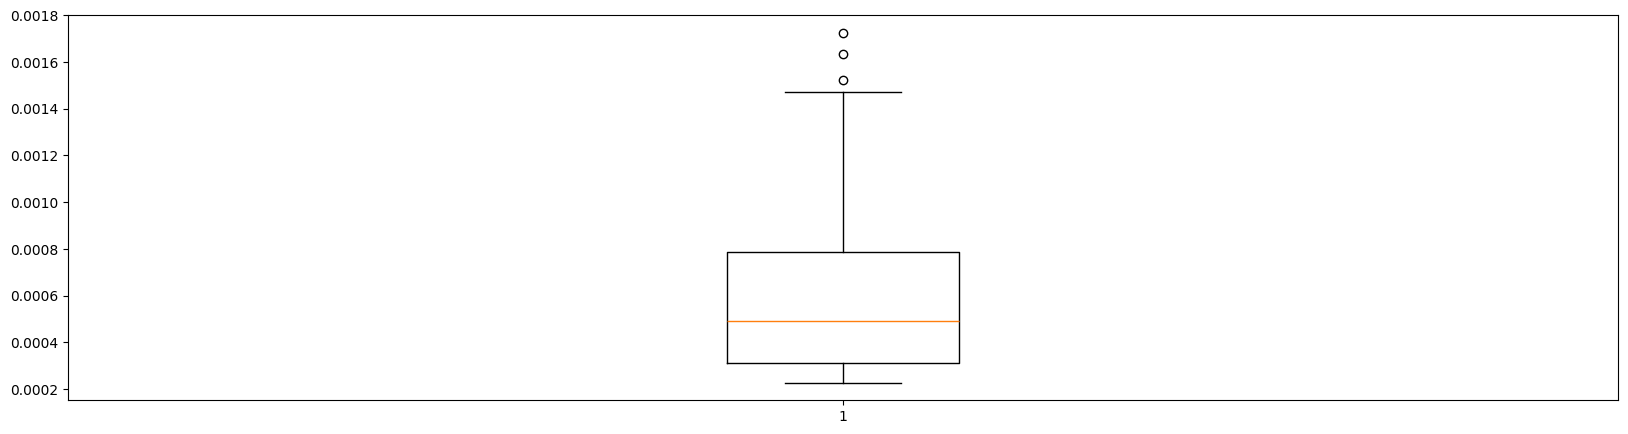

In [11]:
plt.boxplot(div_der)
plt.show()

In [12]:
hdf5_file='results/erdos_results_rho=1.1_p_thin=0.1.h5'
with h5py.File(hdf5_file, 'r') as file:

    div_der = []
    div_pos = []

    for group_name in file.keys():
        group = file[group_name]
        if 'mean_vpt_thinned' not in list(group.attrs):
            continue
        print(group_name)
        div_der.append(group['div_der_thinned'][0])
        div_pos.append(group['div_pos_thinned'][0])
        # print('{}, c: {}, vpt_connected: {}, p_thin: {}, vpt_thinned: {}'.format(group_name, c, vpt_connected, p_thin, vpt_thinned))
    # print('vpt_connected_average: {}, vpt_thinned_average: {}'.format(np.mean(vpt_connected_list), np.mean(vpt_thinned_list)))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'results/erdos_results_rho=1.1_p_thin=0.1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

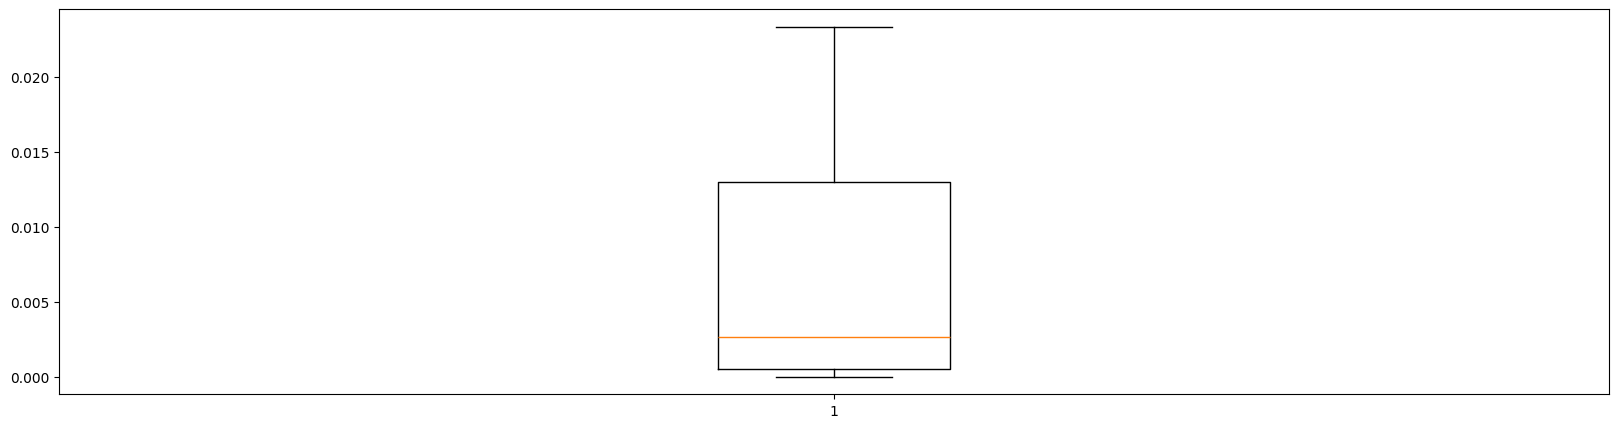

In [ ]:
plt.boxplot(div_der)
plt.show()

### Variance of the Diversity Metrics Analysis

In [ ]:
print(np.mean(mean_values[1]), np.mean(mean_values[2]))
print(np.mean(mean_values[2][np.isfinite(mean_values[2])]))
print(np.mean(mean_values[1][np.isfinite(mean_values[1])]))
print(np.max(mean_values[2][np.isfinite(mean_values[2])]))
print(np.max(mean_values[1][np.isfinite(mean_values[1])]))
print(np.min(mean_values[2][np.isfinite(mean_values[2])]))
print(np.min(mean_values[1][np.isfinite(mean_values[1])]))

0.20007535993809303 0.007923879750052047
0.007923879750052047
0.20007535993809303
0.011753626626877588
0.30031223639171917
0.003365112469191298
0.0814023577891114


In [ ]:
mean_vpts, mean_pos_divs, mean_der_divs, mean_consistencies = np.isfinite(mean_values)

In [ ]:
print(np.max(mean_pos_divs), np.max(mean_der_divs))
print(np.min(mean_pos_divs), np.min(mean_der_divs))
print(np.sum(mean_pos_divs > 10000), np.sum(mean_der_divs > 10000))
pos_flat = mean_pos_divs.flatten()
der_flat = mean_der_divs.flatten()
print(len(der_flat))
cov = np.cov(pos_flat, der_flat)
print(cov)

True True
True True
0 0
162
[[0. 0.]
 [0. 0.]]


In [ ]:
print(np.divide(mean_pos_divs, mean_der_divs))

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
threshold = 10

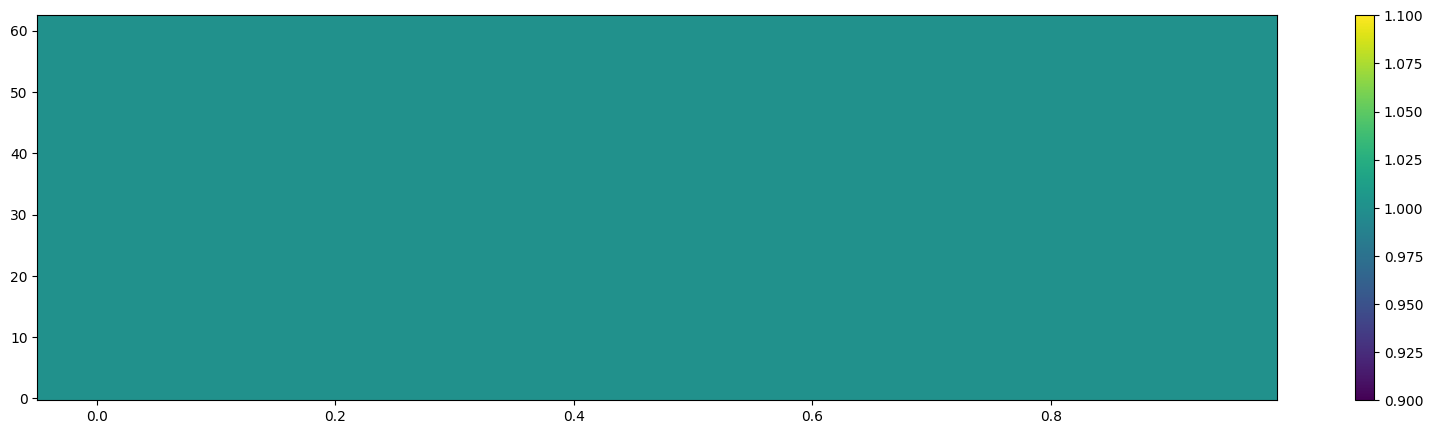

In [ ]:
X, Y = np.meshgrid(p_thins, rhos)
# ax.pcolormesh(X, Y, values, shading='nearest', norm=norm, cmap=cmap)
plot_pos_divs = np.copy(mean_pos_divs)
plot_pos_divs[plot_pos_divs > threshold] = 0
plt.pcolormesh(X, Y, plot_pos_divs)
plt.colorbar()
plt.show()
plt.close()

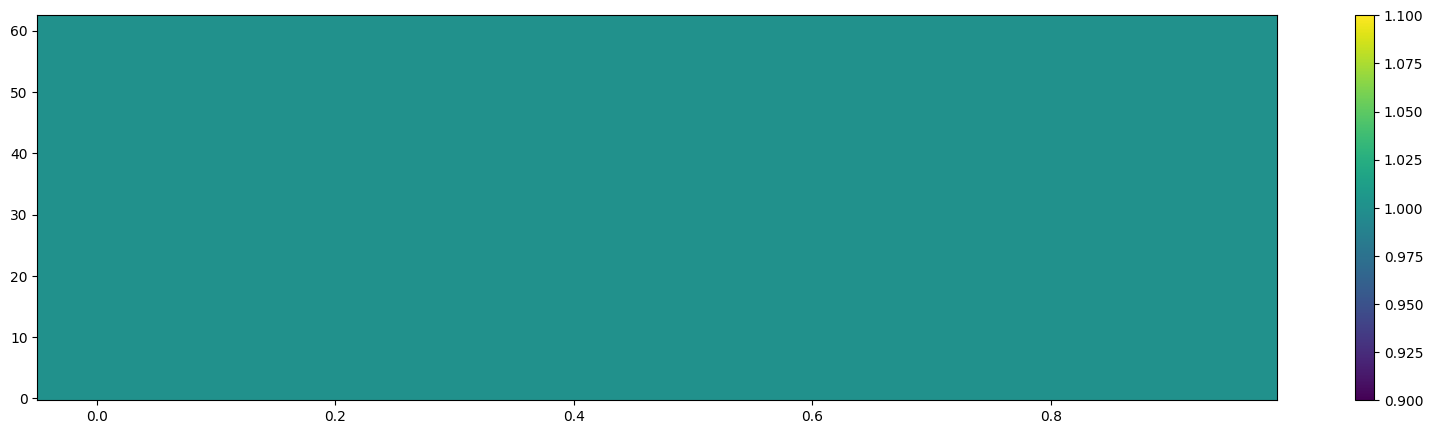

In [ ]:
X, Y = np.meshgrid(p_thins, rhos)
# ax.pcolormesh(X, Y, values, shading='nearest', norm=norm, cmap=cmap)
plot_der_divs = np.copy(mean_der_divs)
plot_der_divs[plot_der_divs > threshold] = 0
plt.pcolormesh(X, Y, plot_der_divs)
plt.colorbar()
plt.show()